## Burenkov Valentyn


In [60]:
import torch
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_moons
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
from helper_functions import plot_predictions, plot_decision_boundary

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [62]:
X, y = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=42)

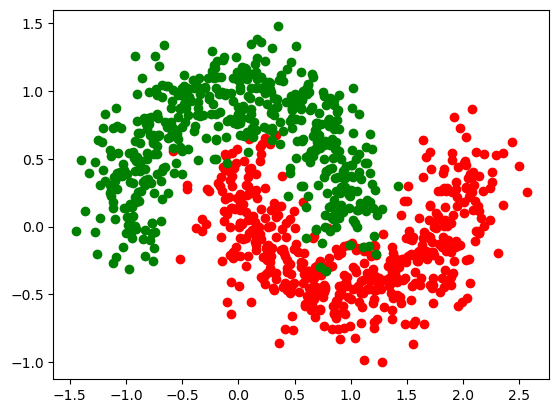

In [63]:
plt.scatter(X[y==1,0], X[y==1, 1], color='r')
plt.scatter(X[y==0,0], X[y==0, 1], color='g')
plt.show()

In [64]:
df = pd.DataFrame({'X1': X[:,0], 'X2': X[:,1], 'Class': y})
df

,X1,X2,Class
0,-0.111667,0.520224,1
1,1.142650,-0.342577,1
2,0.795558,-0.011442,1
3,0.111827,-0.551932,1
4,-0.816466,0.543996,0
...,...,...,...
995,0.835830,0.435532,0
996,-0.195852,0.833794,0
997,1.727608,-0.428829,1
998,-1.014486,0.135229,0


In [65]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [66]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [67]:
# 1. Construct a model class that subclasses nn.Module
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() 
        
        # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# 4. Create an instance of the model and send it to target device
model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [68]:
# Create a loss function
# loss_fn = nn.BCELoss() # Requires sigmoid on input
# Does not require sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [69]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [70]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model.eval()
    
    with torch.inference_mode():
        
        # 1. Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69494, Accuracy: 39.88% | Test loss: 0.69399, Test acc: 50.50%
Epoch: 100 | Loss: 0.40633, Accuracy: 80.62% | Test loss: 0.42149, Test acc: 77.50%
Epoch: 200 | Loss: 0.28933, Accuracy: 87.25% | Test loss: 0.28821, Test acc: 85.50%
Epoch: 300 | Loss: 0.26104, Accuracy: 88.75% | Test loss: 0.25260, Test acc: 88.00%
Epoch: 400 | Loss: 0.24212, Accuracy: 89.88% | Test loss: 0.23061, Test acc: 89.00%
Epoch: 500 | Loss: 0.21760, Accuracy: 90.75% | Test loss: 0.20313, Test acc: 90.50%
Epoch: 600 | Loss: 0.18855, Accuracy: 92.25% | Test loss: 0.17193, Test acc: 92.50%
Epoch: 700 | Loss: 0.15927, Accuracy: 94.25% | Test loss: 0.14097, Test acc: 94.50%
Epoch: 800 | Loss: 0.13621, Accuracy: 95.50% | Test loss: 0.11634, Test acc: 97.00%
Epoch: 900 | Loss: 0.11959, Accuracy: 96.25% | Test loss: 0.09877, Test acc: 97.50%


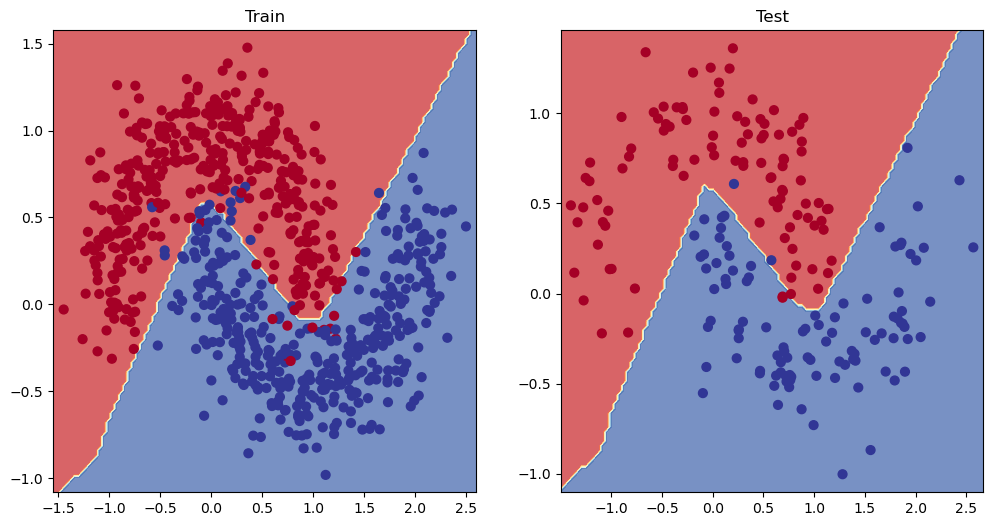

In [71]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)